In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# fix random seeds
rng_seed = 0
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)

from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators.bayesian import ExpectedImprovementGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from lume_model.models import TorchModule

sys.path.append("../")
sys.path.append("calibration_modules/")
import utils
from calibration_modules.decoupled_linear import DecoupledLinear

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## Definition of Objective

In [3]:
# create Xopt vocs
vocs = VOCS.from_yaml(
    """
    variables:
      distgen:r_dist:sigma_xy:value: [0.21021247820852546, 0.4999996083265339]
      distgen:t_dist:length:value: [3.000000758511308, 11.998569812014836]
      SOL1:solenoid_field_scale: [0.19409053333889578, 0.2563030896232562]
      CQ01:b1_gradient: [-0.009999618141995313, 0.0099925212795954]
      SQ01:b1_gradient: [-0.009999490058927914, 0.009999443099573097]
      L0A_phase:dtheta0_deg: [-24.998714513984325, 9.991752397382681]
      L0B_phase:dtheta0_deg: [-24.99972566363747, 9.998904767155892]
      QA01:b1_gradient: [1.000039854940649, 3.998197816908352]
      QA02:b1_gradient: [-3.990444304119449, -1.0105116218007806]
      QE01:b1_gradient: [1.0007061999094193, 6.9997773994714345]
      QE02:b1_gradient: [-6.999887318319171, 0.9983521010385275]
      QE03:b1_gradient: [-6.998418428856965, 0.9993010487139868]
      QE04:b1_gradient: [1.000026533968218, 6.998086093251312]
    constraints: {}
    objectives: {sigma_xy: MINIMIZE}
    constants: {'distgen:total_charge:value': 250.0, 'L0A_scale:voltage': 58000000.0,
      'L0B_scale:voltage': 70000000.0}
    observables: []
    """
)

In [4]:
# create objective model
objective_model = utils.load_model(
    input_variables=vocs.variable_names,
    model_path="../lcls_cu_injector_nn_model/",
    use_sim_model=True,
)
lume_model = objective_model.model.model
lume_module = objective_model.model

In [5]:
# define miscalibrated objective model
mismatch_scale = 0.3
x_size = len(lume_module.input_order)
y_size = len(vocs.objective_names)

miscalibrated_objective_model = DecoupledLinear(
    model=objective_model,
    x_size=x_size,
    y_size=y_size,
    x_offset_initial=mismatch_scale * torch.rand(x_size),
    x_scale_initial=torch.ones(x_size) + mismatch_scale * torch.rand(x_size),
    y_offset_initial=mismatch_scale * torch.rand(y_size),
    y_scale_initial=torch.ones(y_size) + mismatch_scale * torch.rand(y_size),
)
miscalibrated_objective_model.requires_grad_(False);

## Bayesian Approach

### Define Custom Mean and Xopt Config

In [6]:
# define custom mean
custom_mean = DecoupledLinear(
    model=miscalibrated_objective_model,
    x_size=x_size,
    y_size=y_size,
)

In [7]:
def evaluate(input_dict, generator, lume_model, objective_model, noise_level = 0.0):
    model_result = lume_model.evaluate(input_dict)
    sigma_xy = objective_model.function(model_result["sigma_x"], model_result["sigma_y"])
    noise = noise_level * torch.rand(sigma_xy.shape)
    total_size = sigma_xy + noise
    output_dict = {generator.vocs.objective_names[0]: total_size.detach().item()}
    return output_dict

In [8]:
# Xopt definition
gp_constructor = StandardModelConstructor(
    use_low_noise_prior=True,
    mean_modules={vocs.objective_names[0]: custom_mean},
    trainable_mean_keys=[vocs.objective_names[0]],
)
numerical_optimizer = LBFGSOptimizer(n_restarts=5, max_iter=20)
generator = ExpectedImprovementGenerator(
    vocs=vocs,
    gp_constructor=gp_constructor,
    numerical_optimizer=numerical_optimizer,
)
evaluator = Evaluator(function=evaluate)
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
evaluate_kwargs = {
    "generator": X.generator,
    "lume_model": lume_model,
    "objective_model": objective_model,
    "noise_level": 0.0,
}
X.evaluator = Evaluator(function=evaluate, function_kwargs=evaluate_kwargs)

In [9]:
# create initial samples
n_init = 3
X.random_evaluate(n_samples=n_init)

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_phase:dtheta0_deg,L0B_phase:dtheta0_deg,QA01:b1_gradient,QA02:b1_gradient,QE01:b1_gradient,QE02:b1_gradient,QE03:b1_gradient,QE04:b1_gradient,distgen:total_charge:value,L0A_scale:voltage,L0B_scale:voltage,sigma_xy,xopt_runtime,xopt_error
0,0.340961,7.095401,0.229080,0.002327,-0.001361,6.943058,-17.235516,1.602194,-1.362961,1.332641,-1.117627,-3.546874,3.326699,250.0,58000000.0,70000000.0,1.762248,0.001127,False
1,0.292747,8.186283,0.200824,-0.005836,-0.008512,9.284301,-20.450329,2.614610,-2.917433,3.869172,-5.194154,0.849025,3.297679,250.0,58000000.0,70000000.0,1.962777,0.000415,False
2,0.325327,6.186447,0.196351,-0.000581,0.008579,-19.142005,-24.251397,1.658048,-1.437695,4.512191,-2.650047,-3.940374,1.337429,250.0,58000000.0,70000000.0,3.726567,0.000336,False


### Bayesian Optimization

In [10]:
%%time
n_step = 100
for _ in range(n_step):
    X.step()

CPU times: user 23min 57s, sys: 3min 38s, total: 27min 36s
Wall time: 16min 21s


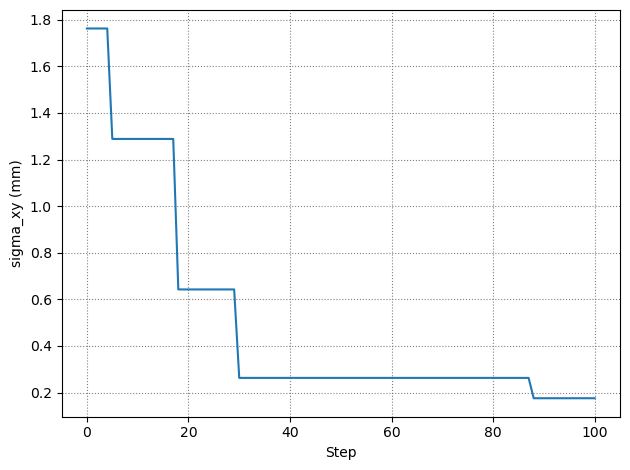

In [11]:
# plot optimization performance
fig, ax = plt.subplots()
ax.plot(torch.arange(n_step + 1), utils.get_running_optimum(X.data, X.vocs.objective_names[0], maximize=False)[n_init - 1:])
ax.set_xlabel("Step")
ax.set_ylabel(f"{vocs.objective_names[0]} (mm)")
ax.grid(color="gray", linestyle=":")
fig.tight_layout()

### Calibration Results

In [12]:
# evaluate input calibration
learned_custom_mean = X.generator.model.models[0].mean_module._model
df = pd.DataFrame(columns=["x_offset", "x_offset_learned", "x_scale", "x_scale_learned"])
for i in range(x_size):
    x_offset = miscalibrated_objective_model.x_offset.detach()[i].item()
    x_offset_learned = -learned_custom_mean.x_offset.detach()[i].item()
    x_scale = miscalibrated_objective_model.x_scale.detach()[i].item()
    x_scale_learned = 1 / learned_custom_mean.x_scale.detach()[i].item()
    df.loc[len(df.index)] = [x_offset, x_offset_learned, x_scale, x_scale_learned]
df

,x_offset,x_offset_learned,x_scale,x_scale_learned
0,0.148877,0.147580,1.050658,1.545765
1,0.230467,0.056188,1.088166,2.117664
2,0.026543,0.036432,1.155557,1.687181
3,0.039609,0.318036,1.209300,9.992797
4,0.092227,0.633975,1.240003,3.901057
5,0.190224,0.653803,1.048309,1.306098
6,0.147028,-0.136846,1.084681,0.709849
7,0.268933,-0.773065,1.204483,0.706172
8,0.136688,-0.419964,1.274558,1.078321
9,0.189692,0.200885,1.119130,1.434628


In [13]:
# evaluate output calibration
learned_custom_mean = X.generator.model.models[0].mean_module._model
df = pd.DataFrame(columns=["y_offset", "y_offset_learned", "y_scale", "y_scale_learned"])
for i in range(y_size):
    y_offset = miscalibrated_objective_model.y_offset.detach()[i].item()
    y_offset_learned = -learned_custom_mean.y_offset.detach()[i].item()
    y_scale = miscalibrated_objective_model.y_scale.detach()[i].item()
    y_scale_learned = 1 / learned_custom_mean.y_scale.detach()[i].item()
    df.loc[len(df.index)] = [y_offset, y_offset_learned, y_scale, y_scale_learned]
df

,y_offset,y_offset_learned,y_scale,y_scale_learned
0,0.285821,0.810209,1.010849,1.456044


## Backprop Approach

### Create Trainable Model and Data Set

In [14]:
# create calibrated model
cal_model = DecoupledLinear(
    model=miscalibrated_objective_model,
    x_size=x_size,
    y_size=y_size,
)
cal_model.to(device)

# define trainable parameters
trainable_params = cal_model.raw_calibration_parameters
trainable_params

[Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True)]

In [15]:
# create data set
x = torch.tensor(
    X.data[vocs.variable_names].values,
    dtype=torch.double,
    device=device,
)
pred = torch.tensor(
    X.data[vocs.output_names].values,
    dtype=torch.double,
    device=device,
).squeeze()

In [16]:
# define data set class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]
        return x, y


# define dataloader
trainloader = torch.utils.data.DataLoader(
    dataset=Dataset(x, pred),
    batch_size=pred.shape[0],
    shuffle=True,
    num_workers=0,
    pin_memory=not "cuda" in device,  # we can't use this if we're on the GPU
)

# define optimizer and loss function
optimizer = torch.optim.Adam(
    params=trainable_params,
    lr=1e-3,
    weight_decay=1e-3,  # regularization favors conservative calibration
)
criterion = torch.nn.L1Loss()

### Training Loop

In [17]:
%%time
# training loop
losses = []
n_epochs = int(1e4)
for epoch in range(n_epochs):
    for i, batch_data in enumerate(trainloader, 0):
        inputs, targets = batch_data
        optimizer.zero_grad()
        outputs = cal_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if i == 0:
            losses.append(loss.item())

CPU times: user 3min 15s, sys: 42.8 s, total: 3min 58s
Wall time: 2min 18s


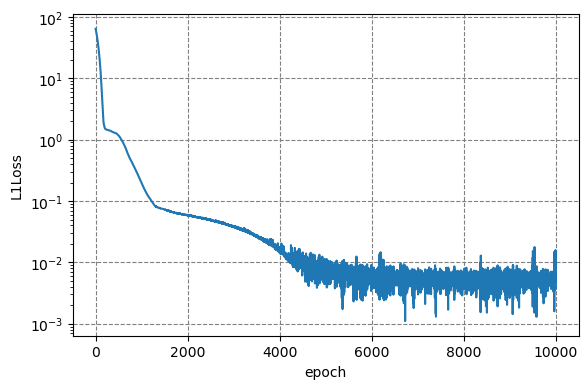

In [18]:
# plot training process
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlabel("epoch")
ax.plot(losses, "C0")
ax.set_ylabel(criterion.__class__.__name__)
ax.grid(color="gray", linestyle="dashed")
ax.set_yscale("log")
fig.tight_layout()

### Calibration Results

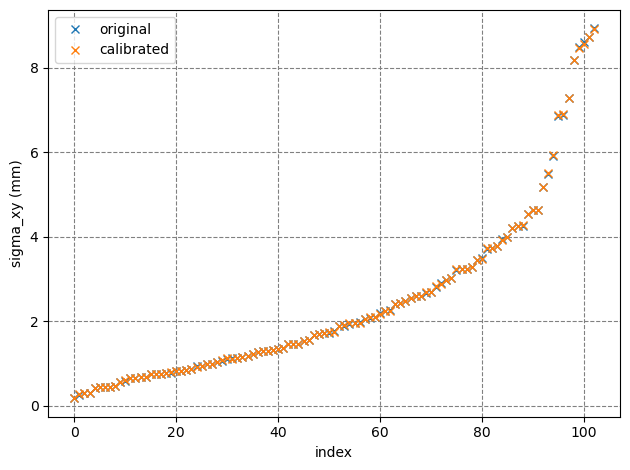

In [19]:
# calibrated predictions
with torch.no_grad():
    cal_pred = cal_model(x)
fig, ax = plt.subplots()
idx_sort = torch.argsort(pred)
ax.plot(pred[idx_sort].cpu(), "C0x", label="original")
ax.plot(cal_pred[idx_sort].cpu(), "C1x", label="calibrated")
ax.grid(color="gray", linestyle="dashed")
ax.set_xlabel("index")
ax.set_ylabel(f"{vocs.objective_names[0]} (mm)")
ax.legend(loc="upper left")
fig.tight_layout()

In [20]:
# calibration parameters
df_x = pd.DataFrame(
    columns=[["x_offset"] * 2 + ["x_scale"] * 2, ["target", "learned"] * 2]
)
df_y = pd.DataFrame(
    columns=[["y_offset"] * 2 + ["y_scale"] * 2, ["target", "learned"] * 2]
)
for df in [df_x, df_y]:
    for col in df.columns:
        model = miscalibrated_objective_model
        if col[-1] == "learned":
            model = cal_model
        values = getattr(model, col[0])
        if col[-1] == "learned":
            if "offset" in col[0]:
                values = -values
            elif "scale" in col[0]:
                values = 1.0 / values
        if values.shape[0] == 1:
            df[col] = values.detach().cpu().tolist()
        else:
            df.loc[:, col] = values.detach().cpu().tolist()
pd.set_option("display.float_format", "{:.4f}".format)

In [21]:
df_x

x_offset         x_scale        
     target learned  target learned
0    0.1489  0.1564  1.0507  1.0506
1    0.2305  0.1901  1.0882  1.0870
2    0.0265  0.0551  1.1556  1.1558
3    0.0396  0.0473  1.2093  1.2091
4    0.0922  0.1140  1.2400  1.2399
5    0.1902  0.1990  1.0483  1.0483
6    0.1470  0.1598  1.0847  1.0847
7    0.2689  0.3230  1.2045  1.2045
8    0.1367  0.1748  1.2746  1.2744
9    0.1897  0.2122  1.1191  1.1188
10   0.1047  0.1320  1.2622  1.2625
11   0.1205  0.1359  1.1258  1.1255
12   0.0067  0.0070  1.1659  1.1662

In [22]:
df_y

y_offset         y_scale        
    target learned  target learned
0   0.2858  0.2889  1.0108  1.0110